### Imports e conexão

In [127]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

In [128]:
server = 'localhost'  # ou o endereço IP do servidor SQL Server
database = 'Neteye'   # nome do banco de dados restaurado
username = 'sa'       # nome de usuário do SQL Server
password = 'YourStrong@Passw0rd'  # senha do usuário


# String de conexão
connection_string = (
    f'DRIVER={{ODBC Driver 18 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password};'
    'TrustServerCertificate=yes;'
)

try:
    # Estabelecer conexão com o banco de dados
    connection = pyodbc.connect(connection_string)
    print("Conexão bem-sucedida!")

except Exception as e:
    print("Erro ao conectar ao banco de dados:", e)

Conexão bem-sucedida!


In [129]:
query = """SELECT * FROM VW_PROGRAMS"""
vw_programs = pd.read_sql_query(query, connection)

query = """SELECT * FROM REGRASCLASSIFICACAO"""
regras_class = pd.read_sql_query(query, connection)

query = """SELECT * FROM CLASSIFICACAOSOFTWARE"""
class_soft = pd.read_sql_query(query, connection)

query = """SELECT * FROM bi.fPRODUTIVIDADE"""
bi_prod = pd.read_sql_query(query, connection)

query = """SELECT * FROM bi.fSESSOES"""
bi_sessoes = pd.read_sql_query(query, connection)

query = """SELECT * FROM USUARIOS"""
usuarios = pd.read_sql_query(query, connection)

query = """SELECT * FROM SETORES"""
setores = pd.read_sql_query(query, connection)

/tmp/ipykernel_161470/1828477103.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vw_programs = pd.read_sql_query(query, connection)
/tmp/ipykernel_161470/1828477103.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  regras_class = pd.read_sql_query(query, connection)
/tmp/ipykernel_161470/1828477103.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  class_soft = pd.read_sql_query(query, connection)
/tmp/ipykernel_161470/1828477103.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or d

#### Análise para usuário de SQ 367

In [130]:
usr = "USUARIO_292"

De que setor ele é?

In [131]:
usuarios.head(1)

,CODCONSOLE,USUARIO,SETOR_ID,ADDINFO1,ADDINFO2,ADDINFO3,ADDINFO4,ADDINFO5,MONITOR,ATIVO,NOME
0,EMPRESA,USUARIO_001,18.0,None,None,None,None,None,3,1,Usuário 001 da Silva


In [132]:
usuarios[usuarios['USUARIO'] == usr]

,CODCONSOLE,USUARIO,SETOR_ID,ADDINFO1,ADDINFO2,ADDINFO3,ADDINFO4,ADDINFO5,MONITOR,ATIVO,NOME
291,EMPRESA,USUARIO_292,31.0,None,None,None,None,None,3,1,Usuário 292 da Silva


In [133]:
setores.head(2)

,SETOR_ID,CODCONSOLE,SETOR,RESPONSABLE,RESP_MAIL,FONE,AVG_SALARY,MONITOR,LDAP_SETOR,LDAP_SETOR_DN,seq
0,1,EMPRESA,TECNOLOGIA DA INFORMAÇÃO,,,,None,0,None,None,35
1,2,EMPRESA,SUPRIMENTOS,,,,None,0,None,None,34


Como é um dia de trabalho desse cara?

In [134]:
bi_prod.SQ_USUARIO.value_counts()

SQ_USUARIO
324    467
328    431
313    349
385    332
311    307
      ... 
70       2
367      1
85       1
46       1
19       1
Name: count, Length: 117, dtype: int64

Adicionando coluna com referencia de dia da semana e de horas trabalhadas.

In [135]:
dias_semana_pt = {
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

In [136]:
days_map = {
    'Monday': 'Segunda-feira', 'Tuesday': 'Terça-feira', 'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira', 'Friday': 'Sexta-feira', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
}

bi_sessoes['DT_SESSAO'] = pd.to_datetime(bi_sessoes['DT_SESSAO'])
bi_sessoes['DIA_SEMANA'] = bi_sessoes['DT_SESSAO'].dt.day_name().map(days_map)

In [137]:
bi_sessoes['HORAS'] = (bi_sessoes['QT_SEGUNDOS'] // 3600 + (bi_sessoes['QT_SEGUNDOS'] % 3600 / 60) / 60).round(2)

In [138]:
bi_sessoes[bi_sessoes['ID_USUARIO'] == usr]

,DT_SESSAO,SQ_USUARIO,ID_USUARIO,LOGIN,LOGOUT,QT_SEGUNDOS,DIA_SEMANA,HORAS
88,2024-08-16,325,USUARIO_292,2024-08-16 18:31:34,2024-08-16 18:31:50,16,Sexta-feira,0.00
115,2024-08-17,325,USUARIO_292,2024-08-17 07:32:37,2024-08-17 23:23:49,57072,Sábado,15.85


Vamos analisar o dia de sexta-feira.

In [150]:
filtered_df = vw_programs[vw_programs['LOGIN'] == usr]

In [140]:
regras_class.rename(columns={"ID":"REGRA_ID"}, inplace=True)

In [141]:
filtered_df = filtered_df.merge(on="REGRA_ID", right=regras_class[["REGRA_ID", "ID_CLASSIFICACAO"]], how="left").merge(left_on="ID_CLASSIFICACAO", right=class_soft, right_on="ID", how="left")

In [142]:
filtered_df['INITIALDATE'] = pd.to_datetime(filtered_df['INITIALDATE'])

In [155]:
filtered_df

,ID,CODCONSOLE,STATION,HANDLE,ISOPEN,ACTPROGRAM,IP,URL,INITIALDATE,ACTPROC,LOGIN,FINALDATE,COUNTMIN,REMOTEPORT,REGRA_ID,ORIGEM_HORA
1265,5434,EMPRESA,ESTACAO055,1573356,0,Autenticação em processos (WLAB2024A-028),177.36.181.194,,2024-08-17 07:56:42,JAVAW.EXE,USUARIO_292,2024-08-17 07:56:52,0.183333,56313,30.0,0
1267,5136,EMPRESA,ESTACAO055,262624,0,Menu Gestão Laboratorial (TMNULAB-528),177.36.181.194,,2024-08-17 07:33:09,JAVAW.EXE,USUARIO_292,2024-08-17 08:38:52,0.000000,56313,30.0,0
1268,5140,EMPRESA,ESTACAO055,262844,0,Coleta de Materiais (WLAB2024-303),177.36.181.194,,2024-08-17 07:33:09,JAVAW.EXE,USUARIO_292,2024-08-17 08:38:52,42.150000,56313,30.0,0
1269,5147,EMPRESA,ESTACAO055,131570,0,Autenticação em processos (WLAB2024A-028),177.36.181.194,,2024-08-17 07:34:03,JAVAW.EXE,USUARIO_292,2024-08-17 07:34:13,0.183333,56313,30.0,0
1270,5663,EMPRESA,ESTACAO055,1704086,0,,177.36.181.194,,2024-08-17 08:08:32,JAVAW.EXE,USUARIO_292,2024-08-17 08:08:43,0.000000,56313,30.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9162,6517,EMPRESA,ESTACAO055,-603,0,Computador ocioso,177.36.181.194,None,2024-08-17 08:52:30,Ocioso,USUARIO_292,2024-08-17 08:52:41,0.183333,63850,NaN,0
9163,6021,EMPRESA,ESTACAO055,-603,0,Computador ocioso,177.36.181.194,None,2024-08-17 08:26:50,Ocioso,USUARIO_292,2024-08-17 08:30:53,4.033333,56313,NaN,0
9164,6026,EMPRESA,ESTACAO015,-1,0,Computador ocioso,187.109.110.227,None,2024-08-17 08:27:07,Ocioso,USUARIO_292,2024-08-17 08:30:48,3.700000,49902,NaN,0
9165,7135,EMPRESA,ESTACAO055,-603,0,Computador ocioso,177.36.181.194,None,2024-08-17 09:26:58,Ocioso,USUARIO_292,2024-08-17 09:31:13,4.233333,63850,NaN,0


In [144]:
filtered_df.shape

(171, 20)

In [145]:
filtered_df.isna().sum()

ID_x                   0
CODCONSOLE             0
STATION                0
HANDLE                 0
ISOPEN                 0
ACTPROGRAM             0
IP                     0
URL                   50
INITIALDATE            0
ACTPROC                0
LOGIN                  0
FINALDATE              0
COUNTMIN               0
REMOTEPORT             0
REGRA_ID              82
ORIGEM_HORA            0
ID_CLASSIFICACAO      82
ID_y                  82
CLASSIFICACAO         82
PRODUCTIVITY_LEVEL    82
dtype: int64

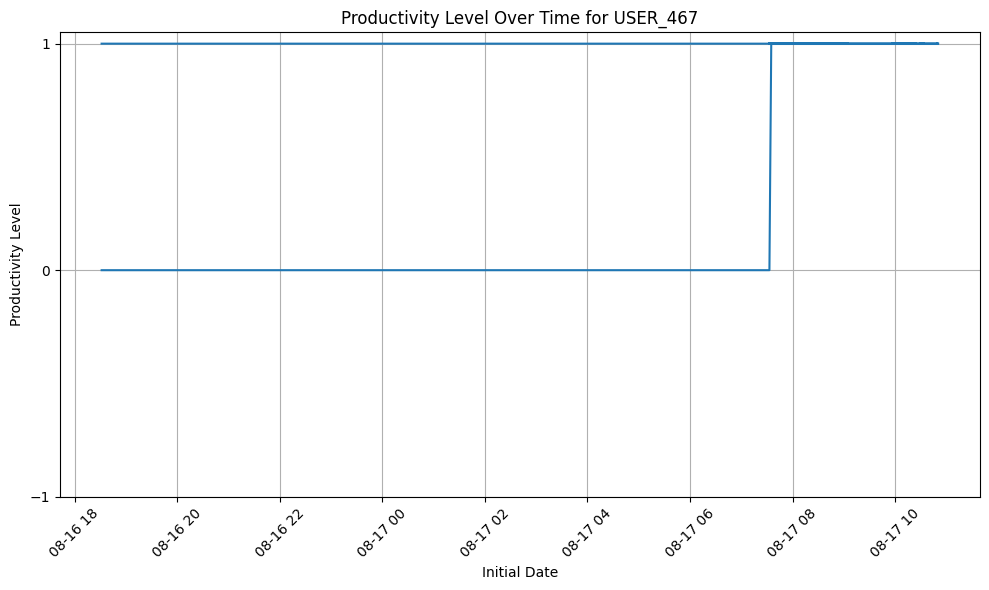

In [146]:
# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['INITIALDATE'], filtered_df['PRODUCTIVITY_LEVEL'])
plt.title('Productivity Level Over Time for USER_467')
plt.xlabel('Initial Date')
plt.ylabel('Productivity Level')
plt.yticks([-1, 0, 1])
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [154]:
filtered_df[filtered_df['INITIALDATE'] == '2024-08-17 07:32:37']

,ID,CODCONSOLE,STATION,HANDLE,ISOPEN,ACTPROGRAM,IP,URL,INITIALDATE,ACTPROC,LOGIN,FINALDATE,COUNTMIN,REMOTEPORT,REGRA_ID,ORIGEM_HORA
1413,5123,EMPRESA,ESTACAO015,66060,0,Program Manager,187.109.110.227,,2024-08-17 07:32:37,EXPLORER.EXE,USUARIO_292,2024-08-17 23:23:43,3.150000,49902,18.0,0
1414,5124,EMPRESA,ESTACAO015,66112,0,,187.109.110.227,,2024-08-17 07:32:37,EXPLORER.EXE,USUARIO_292,2024-08-17 23:23:43,0.000000,49902,18.0,0
1419,5126,EMPRESA,ESTACAO015,131642,0,,187.109.110.227,,2024-08-17 07:32:37,EXPLORER.EXE,USUARIO_292,2024-08-17 23:23:43,0.000000,49902,18.0,0
1420,5127,EMPRESA,ESTACAO015,66140,0,,187.109.110.227,,2024-08-17 07:32:37,EXPLORER.EXE,USUARIO_292,2024-08-17 07:32:53,0.000000,49902,18.0,0
1421,5129,EMPRESA,ESTACAO015,66108,0,,187.109.110.227,,2024-08-17 07:32:37,EXPLORER.EXE,USUARIO_292,2024-08-17 23:23:43,0.000000,49902,18.0,0
1422,5130,EMPRESA,ESTACAO015,66148,0,,187.109.110.227,,2024-08-17 07:32:37,EXPLORER.EXE,USUARIO_292,2024-08-17 23:23:43,0.000000,49902,18.0,0
1423,5131,EMPRESA,ESTACAO015,65838,0,,187.109.110.227,,2024-08-17 07:32:37,EXPLORER.EXE,USUARIO_292,2024-08-17 23:23:43,0.000000,49902,18.0,0
2725,5128,EMPRESA,ESTACAO015,66516,0,Conexão de Área de Trabalho Remota,187.109.110.227,,2024-08-17 07:32:37,MSTSC.EXE,USUARIO_292,2024-08-17 07:32:53,0.266667,49902,51.0,0
3626,5121,EMPRESA,ESTACAO015,66110,0,,187.109.110.227,,2024-08-17 07:32:37,EXPLORER.EXE,USUARIO_292,2024-08-17 23:23:43,0.000000,49902,18.0,0
3650,5125,EMPRESA,ESTACAO015,66650,0,Experiência de Entrada do Windows,187.109.110.227,,2024-08-17 07:32:37,TEXTINPUTHOST.EXE,USUARIO_292,2024-08-17 23:23:43,0.000000,49902,NaN,0


In [147]:
filtered_df.dropna(inplace=True)

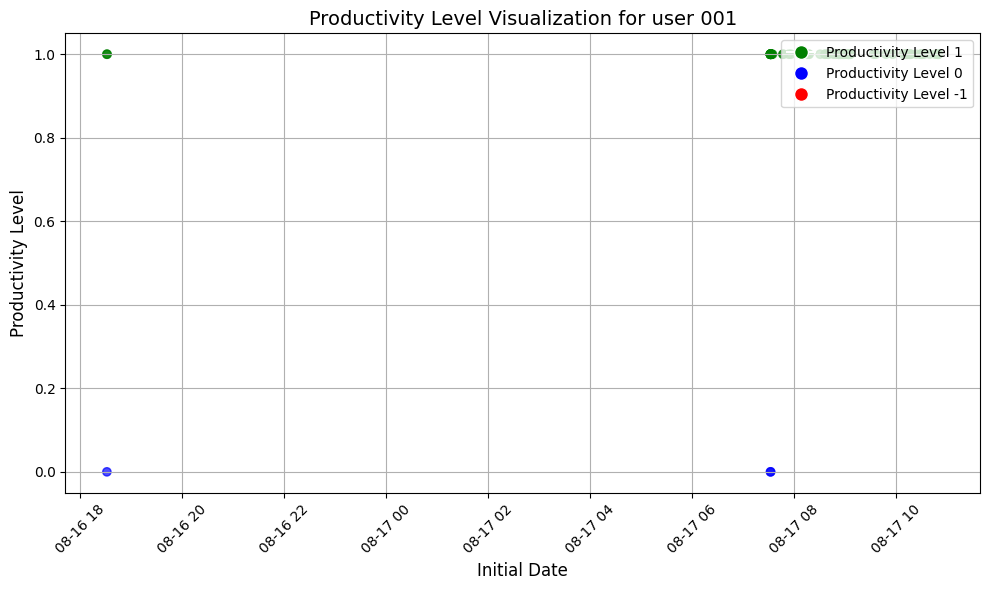

In [148]:
plt.figure(figsize=(10, 6))

# Color coding based on productivity level
colors = filtered_df['PRODUCTIVITY_LEVEL'].map({1: 'green', 0: 'blue', -1: 'red'})

plt.scatter(filtered_df['INITIALDATE'], filtered_df['PRODUCTIVITY_LEVEL'], color=colors, alpha=0.7)

# Improving labels and title
plt.title('Productivity Level Visualization for user 001', fontsize=14)
plt.xlabel('Initial Date', fontsize=12)
plt.ylabel('Productivity Level', fontsize=12)
plt.xticks(rotation=45)

# Adding grid for better readability
plt.grid(True)

# Adding a legend to explain color coding
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Productivity Level 1'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Productivity Level 0'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Productivity Level -1')]

plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()